#**Imputation Statistics Gathering**

For the training of the imputation algorithm "reccomendation" multiclass machine learning model we need each dataset for each missingness mechanism to have recorded the imputation algorithm that was most accuracy at replacing missing data points with formulated estimates.

We set up all of the specified imputation algorithms for this project and we run them on each dataset for each missingness mechanism and save the information inside a json file inside each missingness mechansims file. This json file will contain the name of each file as a key with its value as the imputation algorithm which was optimal for this dataset.

#Mounting the Google drive

This allows us to access all the data we store in this project as well at the file system

In [ ]:
# Need to mount drive to access and save files that store model stats, figures, etc
from google.colab import drive
import os


# Mount the drive
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Final_year_project") # Path of reference for imports
folder = os.path.join("/content/drive/MyDrive/Final_year_project") # Reference for future use when importing / exporting files

# View files in the current working directory
!ls

Mounted at /content/drive
data
datasets
getImputationModelsStats.ipynb
getMissingData.ipynb
imputationRecommendationModel.ipynb
imputationRecommendationModelRandomForest.ipynb
machine_learning_model
pipeline.ipynb
random_forest_machine_learning_model
root


# Imports and installs

This section import and/or installs all neccessary python libraries

In [ ]:
# pip installs
!pip install fancyimpute
!pip install MissForest
!pip install scikit-learn numpy pandas
!pip install miceforest


# Imports
from fancyimpute import IterativeImputer
from fancyimpute import KNN
from missforest import MissForest
from sklearn.linear_model import BayesianRidge
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from scipy import stats
import miceforest as miceforest
import os
import gc
import zipfile
import pandas as pd
import shutil
import random
import numpy as np
import time
import json

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.4 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=9bd4ece11957206bfc27d8af2317ca7133a61ba3fe87b32663cfd2c6caa3d2e1
  Stored in directory: /root/.cache/pip/wheels/1a/f3/a1/f7f10b5ae2c2459398762a3fcf4ac18c325311c7e3163d5a15
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11331 sha256=f175930e27043affea4eb4ce15f59278492514a2208cdb2db4128484f275dc77
  Stored in directory: /root/.cache/pip/wheels/ea/e8/e0/79872972161e54486517ae507f94b2c7cea27fb7ef793bd415
Successfully built fancyimpute knnimpute
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 kB 3.4 MB/s eta 0:00:00


# Dataset metafeatures extraction





#### Statistical metafeatures

This section contains functionality to extract the statical metafeatures from the cleaned / pre-proccessed dataset. These metafeatures are taken from a reference paper and contained in the following table

In [ ]:
def get_statistical_metafeatures(df: pd.DataFrame, missingness_column: str) -> dict[str, int]:
    """
    Return a dict of metafeatures under the typical 'simple' category
    """

    mf_simple = {}



    # Metafeatures not in the table

    # Number of Samples (rows)
    mf_simple["n_samples"] = float(len(df)) # Check this is best way of getting rows

    # Number of continuous features
    mf_simple["n_cols_continuous"]  = float(len(df.select_dtypes(include=["int64", "float64"]).columns))

    # Number of categorical features
    mf_simple["n_cols_categorical"] = float(len(df.select_dtypes(include=["object", "category"]).columns))

    # Log number of features over samples
    mf_simple["log_n_features_over_n_samples"] = float(np.log(len(df.columns)/len(df)))



    # Metafeature in the table

    # Number of patterns
    mf_simple["n_patterns"] = float(df.shape[0])

    # Log number of patterns
    mf_simple["log_n_patterns"] = float(np.log(df.shape[0]))

    # Number of Features (cols)
    mf_simple["n_features"] = float(df.shape[1])

    # Log number of features
    mf_simple["log_n_features"] = float(np.log(df.shape[1]))

    # Number of patterns with missing values
    mf_simple["n_patterns_with_missing"] = float(df.isna().any(axis=1).sum())

    # Percentage of patterns with missing values
    mf_simple["p_patterns_with_missing"] = float(df.isna().any(axis=1).sum() / df.shape[0] * 100)

    # Number of features with missing values
    mf_simple["n_features_with_missing"] = float(df.isna().any(axis=0).sum())

    # Percentage of features with missing values
    mf_simple["p_features_with_missing"] = float(df.isna().any(axis=0).sum() / df.shape[1] * 100)

    # Number of missing values
    mf_simple["n_missing_values"] = float(df.isna().sum().sum())

    # Percentage of missing values
    mf_simple["p_missing_values"] = float(df.isna().sum().sum() / (df.shape[0] * df.shape[1]) * 100)

    # Number of numeric features
    mf_simple["n_numeric_features"] = float(df.select_dtypes(include=["int64", "float64", "number"]).shape[1])

    # Number of categorical features
    mf_simple["n_categorical_features"] = float(df.select_dtypes(include=['object', 'category']).shape[1])

    # Ratio of numeric features to categorical features
    mf_simple["r_continuous_categorical"] = float(mf_simple["n_numeric_features"] / mf_simple["n_categorical_features"] if not mf_simple["n_categorical_features"] == 0 else mf_simple["n_numeric_features"])

    # Ratio of categorical features to numeric features
    mf_simple["n_categorical_continuous"] = float(mf_simple["n_categorical_features"] / mf_simple["n_numeric_features"] if not mf_simple["n_numeric_features"] == 0 else mf_simple["n_categorical_features"])

    # Dimensionality of the dataset
    mf_simple["d_dataset"] = float(sum(_ for _ in df.shape))

    # Log dimensionality of the dataset
    mf_simple["log_d_dataset"] = float(np.log(sum(_ for _ in df.shape)))

    # Inverse dimensionality of the dataset
    mf_simple["inv_d_dataset"] = float(1 / sum(_ for _ in df.shape))

    # Log inverse dimensionality of the dataset
    mf_simple["log_inv_d_dataset"] = float(np.log(1 / sum(_ for _ in df.shape)))

    # Get the average variance from numeircal columns
    mf_simple["variance"] = float(np.mean([df[column].var() for column in df.select_dtypes(include=["int64", "float64"]).columns]))

    # Get the average mean from numeircal columns
    mf_simple["mean"] = float(np.mean([df[column].mean() for column in df.select_dtypes(include=["int64", "float64"]).columns]))



    return mf_simple

#### Missingness metafeatures

This section contains functionality to extract the missingness metafeatures  from the cleaned / pre-proccessed dataset. These metafeatures include information about the missing data such as the proportion of missing data the missing data type, missing data mechansim, etc

In [ ]:
def get_missingness_metafeatures(df: pd.DataFrame, missingness_column, missingness_mechansim) -> dict[str, int]:
    """
    Return a dict of metafeatures
    """

    missingness_mechansim_map = {
        "MCAR": 0,
        "MAR": 1,
        "MNAR": 2
    }
    missingness_mechansim_map_inverse = {value: key for key, value in missingness_mechansim_map.items()}

    mf_missingness = {}


    # Create copy of the dataframe
    df_copy = df.copy()


    # Encode column if is categorical
    if not pd.api.types.is_numeric_dtype(df_copy[missingness_column]):
        encoder = LabelEncoder()
        df_copy[missingness_column] = encoder.fit_transform(df_copy[missingness_column])
        mf_missingness["is_numeric"] = float(0) #(False)

    else:
        mf_missingness["is_numeric"] = float(1) #(False)


    # Get encoded missingness mechansim
    mf_missingness["missingness_mechansim"] = float(missingness_mechansim_map[missingness_mechansim.strip().upper()])




    # Metafeature extraction - General statistics

    # # Mean of the missingness column
    # mf_missingness["mean"] = float(df_copy[missingness_column].mean())

    # # Variance of the missingness column
    # mf_missingness["variance"] = float(df_copy[missingness_column].var())

    # Median of the missingness column
    mf_missingness["median"] = float(df_copy[missingness_column].median())

    # Mode of the missingness column
    mf_missingness["mode"] = float(df_copy[missingness_column].mode().iloc[0])

    # Standard deviation of the missingness column
    mf_missingness["std"] = float(df_copy[missingness_column].std())

    # Minimum of the missingness column
    mf_missingness["min"] = float(df_copy[missingness_column].min())

    # Maximum of the missingness column
    mf_missingness["max"] = float(df_copy[missingness_column].max())

    # Range of the missingness column
    mf_missingness["range"] = float(df_copy[missingness_column].max() - df_copy[missingness_column].min())

    # Skewness of the missingness column
    mf_missingness["skewness"] = float(df_copy[missingness_column].skew())

    # Kurtosis of the missingness column
    mf_missingness["kurtosis"] = float(df_copy[missingness_column].kurt())

    # Interquartile range of the missingness column
    mf_missingness["iqr"] = float(df_copy[missingness_column].quantile(0.25) - df_copy[missingness_column].quantile(0.75))



    # Metafeature extraction - Data quality

    # Number of unqiue values in the missingness column
    mf_missingness["n_unique_values"] = float(df_copy[missingness_column].nunique())

    # Constant of the missingness column
    mf_missingness["constant"] = float(len(df[df_copy[missingness_column].isin([df_copy[missingness_column].mode()])]) / df_copy.shape[0])



    # Metafeature extraction - Entropy & Variability

    # Shannon entropy of the missingness dataset
    mf_missingness["shannon_entropy"] = float(-np.sum(df_copy.value_counts(normalize=True) * np.log2(df_copy.value_counts(normalize=True))))

    # Coefficient of variation of the missingness dataset
    mf_missingness["coefficient_of_variation"] = float(np.mean(df_copy.std()) / np.mean(df_copy.mean()))

    # Signal-to-noise ratio of variation of the missingness dataset
    mf_missingness["signal_to_noise_ration"] = float(np.mean(df_copy.mean()) / np.mean(df_copy.std()))



    # Metafeature extraction - Missingness stats

    # # Number of missing values in the missingness column
    # mf_missingness["n_missing_values"] = float(len(list(df_copy[missingness_column].isna())))

    # # Missingness ration of the missingness column
    # mf_missingness["p_missing_values"] = float(len(list(df_copy[missingness_column].isna())) / len(list(df_copy[missingness_column])) * 100)




    return mf_missingness

# Imputation algorithms

In this section we setup and test each imputation algorithm that we are going to use when training the imputation algorithm "reccomendation" multiclass machine learning model (all of these algorithms along with there full specification and description are recorded in the project documentation)

#### Mean / Mode / Median imputation algorithm

In mean / mode / median imputation missing categorical values are replaced with the mode of the observed values, whilst missing continuous numerical values are replaced with the mean or median of the observed values.

In [ ]:
def mean_mode_median_imputation(df, column, is_classification):

  # Avoid error by changing null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Create missingness map
  missingness_map = df[column].isna()


  # Use mean if data type is continuous and mode if it's classification
  if is_classification:
      df[column].fillna(df[column].mode()[0], inplace=True)

  else:
      df[column].fillna(df[column].mean(), inplace=True)


  # Find list of predictions
  predictions = list(df[missingness_map][column])


  return df, predictions

#### Last observation carried forward (LOCF) imputation

In last observation carried forward imputation the current missing data point to be addressed is replaced with the value of the last observation whose data point of this variable isn’t missing

In [ ]:
def locf_imputation(df, column):

  # Avoid error by changing null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Create missingness map
  missingness_map = df[column].isna()


  # Fill the first row's missing values incase it has no value to foward fill (will leave missingn values until there isn't one)
  if not df[column].iloc[0]:
    df[column].iloc[0] = df[column].mode()[0]


  # Simply use the pandas "ffill" (forward fill) in-built method
  df[column].fillna(method='ffill', inplace=True)

  # Find list of predictions
  predictions = list(df[missingness_map][column])


  return df, predictions

#### Next observation carried forward (NOCF) imputation

In next observation carried forward imputation the current missing data point to be addressed is replaced with the value of the next observation whose data point of this variable isn’t missing

In [ ]:
def nocf_imputation(df, column):

  # Avoid error by changing null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Create missingness map
  missingness_map = df[column].isna()


  # Fill the first row's missing values incase it has no value to foward fill (will leave missingn values until there isn't one)
  if not df[column].iloc[-1]:
    df[column].iloc[-1] = df[column].mode()[0]


  # Simply use the pandas "bfill" (backward fill) in-built method
  df[column].fillna(method='bfill', inplace=True)

  # Find list of predictions
  predictions = list(df[missingness_map][column])


  return df, predictions

#### Regression imputation

In regression imputation missing values are replaced by using a regression models estimation. The regression model is estimated using the observed values of the dependent variable (target value) Y and the independent variables. The model can be used to predict values for missing cases of Y based on the record’s dependent variables

In [ ]:
def regression_imputation(df, column, is_classification, unencode):

  # Avoid error by changing vall null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Copy original dataframe to reduce data loss (mainly of data typing)
  df_original = df.copy()

  # Create missingness map
  missingness_map = df[column].isna()

  # Store dependant columns original data type
  original_dtype = df[column].dtype

  # Get a list of all other features than the given column
  independant_features = [independant_column for independant_column in df.columns if independant_column != column]

  # Handle the dependant column being classification based (not numeric in a sense) - encode
  dependant_encoder = LabelEncoder()


  if is_classification:
    df[df[column].notna()] = df[df[column].notna()].astype(str)
    df.loc[df[column].notna(), column] = dependant_encoder.fit_transform(df.loc[df[column].notna(), column])
    df[column] = pd.to_numeric(df[column], errors='coerce')


  # Handle the independent columns not being numeric
  for independant_column in independant_features:


    # Encode the column if it's data is not numeric
    if not pd.api.types.is_numeric_dtype(df[independant_column]):

      # Initialize LabelEncoder
      encoder = LabelEncoder()

      # Encode column
      df[independant_column] = df[independant_column].astype(str)
      df[independant_column] = encoder.fit_transform(df[independant_column])
      df[independant_column] = pd.to_numeric(df[independant_column], errors='coerce')

  # Figure out encoded boundaries for the missing column
  encoded_min = df[column].min()
  encoded_max = df[column].max()

  # Gather train data
  train_data = df.dropna()

  # Train a linear regression model independant columns
  X_train = train_data[independant_features]
  y_train = train_data[column]

  # Determine regression model based on task type
  model = LogisticRegression() if is_classification else LinearRegression()
  model.fit(X_train, y_train)

  # Gather test data
  test_data = df[df[column].isna()]
  X_test = test_data[independant_features]

  # Remove any null values in the independant columns by imputing missing values with the mean value of each column
  imputer = SimpleImputer(strategy='mean')
  X_test_imputed = imputer.fit_transform(X_test)

  original_predictions = model.predict(X_test_imputed)


  # Handle the dependant column being classification based (not numeric in a sense) - unencode
  if is_classification:

    # Make sure predictions are positive and rounded to the nearest integer
    original_predictions = [int(np.round(prediction)) if prediction > 0 else 0 for prediction in original_predictions]


    # Unencode data - can't unencode is already encoded outside this function
    if unencode:
      original_predictions = np.clip(original_predictions, encoded_min, encoded_max, out=None)
      df_original.loc[df_original[column].isna(), column] = dependant_encoder.inverse_transform(original_predictions)

    else:
      # Replace the missing values with the predicted values in the original unencoded dataframe
      df_original.loc[df_original[column].isna(), column] = original_predictions

  else:

    # Replace the missing values with the predicted values in the original unencoded dataframe
    df_original.loc[df_original[column].isna(), column] = original_predictions


  # Convert column back to original data type
  df_original[column] = df_original[column].astype(original_dtype)

  predictions = list(df_original[missingness_map][column])


  return df_original, predictions

#### Multivariate imputation by chained equations (MICE)

In multivariate imputation by chained equations multiple datasets are created through a series of regression based models that are iteratively fit to the missing value variable (using the observed data) until convergence of the imputed values with the initial guesses (mean / mode / median imputation) Finally the multiple datasets are combined (usually giving an average of the imputed values) helping incorporate uncertainty introduced by the missingness of the data

In [ ]:
def mice_imputation(df, column, is_classification, unencode):

  # Avoid error by changing vall null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Copy original dataframe to reduce data loss (mainly of data typing)
  df_original = df.copy()

  # Create missingness map
  missingness_map = df[column].isna()

  # Store dependant columns original data type
  original_dtype = df[column].dtype

  # Find all categories
  categories = [independant_column for independant_column in df.columns if not pd.api.types.is_numeric_dtype(df[independant_column]) and not independant_column == column]
  encoder = LabelEncoder()


  # Encode all categories
  for independant_column in categories:
    df[independant_column] = encoder.fit_transform(df[independant_column].astype(str))


  # Handle the dependant column being classification based (not numeric in a sense) - encode
  dependant_encoder = LabelEncoder()


  if is_classification:
    df[df[column].notna()] = df[df[column].notna()].astype(str)
    df.loc[df[column].notna(), column] = dependant_encoder.fit_transform(df.loc[df[column].notna(), column])


  # Figure out encoded boundaries for the missing column
  encoded_min = df[column].min()
  encoded_max = df[column].max()

  # Perform mice imputation
  mice_imputer = IterativeImputer()
  df_imputed = pd.DataFrame(mice_imputer.fit_transform(df.astype(float)), columns=df.columns)


  # Handle the dependant column being classification based (not numeric in a sense) - unencode
  if is_classification:

    # Make sure predictions are positive and rounded to the nearest integer
    df_imputed[column] = [np.round(prediction) if prediction > 0 else 0 for prediction in df_imputed[column]]


    # Unencode data - can't unencode is already encoded outside this function
    if unencode:
      imputed_values = np.array(df_imputed[column])
      df_imputed[column] = np.clip(imputed_values, encoded_min, encoded_max, out=None)
      df_original[column] = dependant_encoder.inverse_transform(df_imputed[column].astype(int))

    else:
      df_original[column] = df_imputed[column]

  else:

    # Replace the missing values with the predicted values in the original unencoded dataframe
    df_original[column] = df_imputed[column]


  # Convert column back to original data type
  df_original[column] = df_original[column].astype(original_dtype)

  predictions = list(df_original[missingness_map][column])


  return df_original, predictions

#### MissForest imputation

In MissForest imputation a random forest model is trained on the observed data inside the missing value variables (gives predictions for the missing values and replaces / updates them inside the dataset) until convergence of the imputed values with the initial guesses (mean / mode / median imputation)

In [ ]:
def missforest_imputation(df, column, is_classification, unencode):

  # Avoid error by changing vall null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Copy original dataframe to reduce data loss (mainly of data typing)
  df_original = df.copy()

  # Create missingness map
  missingness_map = df[column].isna()

  # Store dependant columns original data type
  original_dtype = df[column].dtype

  # Find all categories
  categories = [independant_column for independant_column in df.columns if not pd.api.types.is_numeric_dtype(df[independant_column]) and not independant_column == column]
  encoder = LabelEncoder()


  # Encode all categories
  for independant_column in categories:
    df[independant_column] = encoder.fit_transform(df[independant_column].astype(str))


  # Handle the dependant column being classification based (not numeric in a sense) - encode
  dependant_encoder = LabelEncoder()


  if is_classification:
    df[df[column].notna()] = df[df[column].notna()].astype(str)
    df.loc[df[column].notna(), column] = dependant_encoder.fit_transform(df.loc[df[column].notna(), column])


  missforest_imputer = MissForest(
      categorical=categories
  )

  df_imputed = pd.DataFrame(missforest_imputer.fit_transform(df.astype(float)), columns=df.columns)


  # Handle the dependant column being classification based (not numeric in a sense) - unencode
  if is_classification:


    # Unencode data - can't unencode is already encoded outside this function
    if unencode:
      df_original[column] = dependant_encoder.inverse_transform(df_imputed[column].astype(int))

    else:
      df_original[column] = df_imputed[column]

  else:

    # Replace the missing values with the predicted values in the original unencoded dataframe
    df_original[column] = df_imputed[column]


  # Convert column back to original data type
  df_original[column] = df_original[column].astype(original_dtype)

  predictions = list(df_original[missingness_map][column].astype(original_dtype))


  return df_original, predictions

#### Bayesian imputation

In Bayesian imputation we utilize Bayesian inference to generate a probabilistic model to estimate the missing values. In Bayesian statistics you have a prior distribution which represents beliefs about the missing values based on the features of the observed data (such as distribution). The posterior distribution is created by combining the likelihood function (described how the observed data is distributed according to the model, given its model parameters) Many values are drawn from the posterior distribution and combined to give the imputed value.

In [ ]:
def bayesian_imputation(df, column, is_classification, unencode):

  # Avoid error by changing vall null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Copy original dataframe to reduce data loss (mainly of data typing)
  df_original = df.copy()

  # Store dependant columns original data type
  original_dtype = df[column].dtype

  # Get a list of all other features than the given column
  independant_features = [independant_column for independant_column in df.columns if independant_column != column]

  # Handle the dependant column being classification based (not numeric in a sense) - encode
  dependant_encoder = LabelEncoder()


  if is_classification:
    df[df[column].notna()] = df[df[column].notna()].astype(str)
    df.loc[df[column].notna(), column] = dependant_encoder.fit_transform(df.loc[df[column].notna(), column])


  # Handle the independent columns not being numeric
  for independant_column in independant_features:


    # Encode the column if it's data is not numeric
    if not pd.api.types.is_numeric_dtype(df[independant_column]):

      # Initialize LabelEncoder
      encoder = LabelEncoder()

      # Encode column
      df[independant_column] = df[independant_column].astype(str)
      df[independant_column] = encoder.fit_transform(df[independant_column])


  # Figure out encoded boundaries for the missing column
  encoded_min = df[column].min()
  encoded_max = df[column].max()


  # Gather train data
  train_data = df.dropna()

  # Train a linear regression model independant columns
  X_train = train_data[independant_features]
  y_train = train_data[column]


  # Determine regression model based on task type
  model = BayesianRidge()

  model.fit(X_train, y_train)


  #Gather test data
  test_data = df[df[column].isna()]

  X_test = test_data[independant_features]

  original_predictions = model.predict(X_test)


  # Handle the dependant column being classification based (not numeric in a sense) - unencode
  if is_classification:

    # Make sure predictions are positive and rounded to the nearest integer
    original_predictions = [int(np.round(prediction)) if prediction > 0 else 0 for prediction in original_predictions]


    # Unencode data - can't unencode is already encoded outside this function
    if unencode:
      original_predictions = np.clip(original_predictions, encoded_min, encoded_max, out=None)
      df_original.loc[df_original[column].isna(), column] = dependant_encoder.inverse_transform(original_predictions)

    else:
      df_original.loc[df_original[column].isna(), column] = original_predictions

  else:

    # Replace the missing values with the predicted values in the original unencoded dataframe
    df_original.loc[df_original[column].isna(), column] = original_predictions


  # Convert column back to original data type
  df_original[column] = df_original[column].astype(original_dtype)

  # Define missingness_map here, within the function's scope
  missingness_map = df_original[column].isna()
  predictions = list(df_original[missingness_map][column])


  return df_original, predictions

#### kNN imputation

In kNN imputation we identify the k-nearest neighbours of the missing data point based on a similarity metric of other features and the missing value is then replaced with Mean / Median / Mode imputation of that set. We calculate the distance (usually using distance Euclidean distance or Pearson correlation) between the missing data point and all data points with the observed variable and choose the k closest.

In [ ]:
def kNN_imputation(df, column, is_classification, unencode):

  # Avoid error by changing vall null values to NaN
  df.replace([None, 'None', 'NaT', 'NaN'], np.nan, inplace=True)

  # Copy original dataframe to reduce data loss (mainly of data typing)
  df_original = df.copy()

  # Create missingness map
  missingness_map = df[column].isna()

  # Store dependant columns original data type
  original_dtype = df[column].dtype

  # Find all categories
  categories = [independant_column for independant_column in df.columns if not pd.api.types.is_numeric_dtype(df[independant_column]) and not independant_column == column]
  encoder = LabelEncoder()


  # Encode all categories
  for independant_column in categories:
    df[independant_column] = encoder.fit_transform(df[independant_column].astype(str))


  # Handle the dependant column being classification based (not numeric in a sense) - encode
  dependant_encoder = LabelEncoder()


  if is_classification:
    df[df[column].notna()] = df[df[column].notna()].astype(str)
    df.loc[df[column].notna(), column] = dependant_encoder.fit_transform(df.loc[df[column].notna(), column])


  # Perform kNN imputation
  kNN_imputer = KNN()
  df_imputed = pd.DataFrame(kNN_imputer.fit_transform(df.astype(float)), columns=df.columns)


  # Handle the dependant column being classification based (not numeric in a sense) - unencode
  if is_classification:

    # Make sure predictions are positive and rounded to the nearest integer
    df_imputed[column] = [np.round(prediction) if prediction > 0 else 0 for prediction in df_imputed[column]]


    # Unencode data - can't unencode is already encoded outside this function
    if unencode:
      df_original[column] = dependant_encoder.inverse_transform(df_imputed[column].astype(int))

    else:
      df_original[column] = df_imputed[column]

  else:

    # Replace the missing values with the predicted values in the original unencoded dataframe
    df_original[column] = df_imputed[column]


  # Convert column back to original data type
  df_original[column] = df_original[column].astype(original_dtype)

  predictions = list(df_original[missingness_map][column])


  return df_original, predictions

# Imputation algorithm assessment

In this section we create the functions that are used to assess the effectiveness of an imputation algorithm on a given dataset.

We do this by two methods who's implementations (functions) can be seen below:
1.   Log-transformed root mean squared error (LRMSE)
2.   Average percentage of accuracy



#### Log-transformed root mean squared error (LRMSE)

Log-transformed root mean squared error (LRMSE) can be used to assess the performance of different imputation algorithms. It is scale-invariant, allowing direct comparisons of imputations methods accuracy across different data sets.

In [ ]:
def LRMSE(column_original, column_imputed, is_classification):


  # Encode the arrys if nessessary
  if is_classification:

    combined_columns = np.concatenate((column_original, column_imputed))

    # Initialize LabelEncoder
    encoder = LabelEncoder()

    encoded_combined = encoder.fit_transform(combined_columns)

    column_original = encoded_combined[:len(column_original)]
    column_imputed = encoded_combined[len(column_original):]


  # Calculate the LRMSE - if value is infinite set to 0
  log_original = np.array([log if not np.isinf(log) else 0 for log in np.log(column_original)])
  log_imputed = np.array([log if not np.isinf(log) else 0 for log in np.log(column_imputed)])

  #Compute the root mean squared error (RMSE)
  rmse = np.sqrt(np.mean((log_original - log_imputed)**2))


  return rmse

#### Main Assessment function

This function combines assessment functions to take the Log-transformed root mean squared error (LRMSE) when the imputation tasks is not classification (numeric or continuous) and to take the accuracy (percentage of correctness) when it is a classification task

In [ ]:
def main_assessment(column_original, column_imputed, is_classification):

  main_assessment_accuracy = None


  if is_classification:

    # Use the sklearn accuracy function
    main_assessment_accuracy = accuracy_score([str(_) for _ in column_original], [str(_) for _ in column_imputed])

  else:

    # Use the LRMSE function - invert the functions score to get an accuracy assessment
    main_assessment_accuracy = 1 / LRMSE(column_original, column_imputed, is_classification)


  return main_assessment_accuracy

# Imputation algorithm assessment on datasets

In this section we go through all the datasets in a missiness mechansim file and run all imputation algorithms on this dataset to replace the missing data. Once we have the imputed data we use the LMRSE or Average of percentages accuracy function to assess the quality of imputation algorithms estimation. We use this information to rank to algorithms for the given dataset and record in a key pair format respecively the filename and the most effective imputation algorithm for the dataset inside the file. We do this for each file and store the information and a look-up dictionary stored inside a JSON file in the missingness mechansims file. We repeat this process for each missingness mechansim

In [ ]:
%%capture

shutil.rmtree('/content/temp_folder', ignore_errors=True)

# Specify the paths
download_path = './datasets'
original_path = "./data/Original"
mcar_path = "./data/MCAR"
mar_path = "./data/MAR"
mnar_path = "./data/MNAR"
imputation_stats_folder = "imputation_stats"
imputation_stats_file = "imputation_stats.json"

missingness_mechansims = ["MNAR"]
missingness_datasets = {}


for mechansim in missingness_mechansims:


  """Assess imputation algorithms for MCAR data - as example"""
  mechanism_path = os.path.join("./data", mechansim)

  MCAR_imputation_datasets_stats = {}

  mechansim_datasets_lists = []

  # They should only be json files
  json_files = [file for file in os.listdir(mechanism_path) if file.endswith('.json')]


  for file in json_files:


      try:




          """Assess imputation algorithms for dataset"""

          # Get the datasets needed
          df_mcar = pd.read_json(os.path.join(mechanism_path, file), lines=True)
          df_original = pd.read_json(os.path.join(original_path, file), lines=True)
          mechansim_datasets_lists.append((df_mcar, df_original))

      except:
        _ = 1


  missingness_datasets[mechansim] = mechansim_datasets_lists

In [ ]:
%%capture

shutil.rmtree('/content/temp_folder', ignore_errors=True)

# Specify the paths
download_path = './datasets'
original_path = "./data/Original"
mcar_path = "./data/MCAR"
mar_path = "./data/MAR"
mnar_path = "./data/MNAR"
imputation_stats_folder = "imputation_stats"
imputation_stats_file = "imputation_stats.json"

# Create imputation algorithm lookup for future use
imputation_scores_lookup = {
    0: "Mean / Mode / Median Imputation",
    1: "LOCF Imputation",
    2: "NOCF Imputation",
    3: "Regression Imputation",
    4: "MICE imputation",
    5: "MissForest Imputation",
    6: "Bayesian Imputation",
    7: "kNN Imputation"
}
imputation_scores_lookup_inverse = {value: key for key, value in imputation_scores_lookup.items()}

missingness_mechansims = ["MNAR"]


for mechansim in missingness_mechansims:




  """Assess imputation algorithms for MCAR data - as example"""
  mechanism_path = os.path.join("./data", mechansim)

  MCAR_imputation_datasets_stats = []

  # They should only be json files
  json_datasets = missingness_datasets[mechansim]


  for datasets in json_datasets:


      try:




          """Assess imputation algorithms for dataset"""

          # Get the datasets needed
          df_mcar = datasets[0]
          df_original = datasets[1]

          # print("----------------------------------------------")
          # print(f"MCAR dataframe: \n {df_mcar} \n\n")

          # Get information from the missing data dataset to run the imputation
          missingness_column = df_mcar.columns[df_mcar.isna().any()].tolist()[0]
          isnull_mask = ~df_mcar.drop(columns=[missingness_column]).isnull().any(axis=1)
          df_mcar = df_mcar[isnull_mask]
          df_original = df_original[isnull_mask]
          is_classification = True if not pd.api.types.is_numeric_dtype(df_mcar[missingness_column]) else False
          missingness_map = df_mcar[missingness_column].isna()
          is_encoded = False
          unencode = True
          imputation_scores = [0] * 8
          column_original = list(df_original[missingness_map][missingness_column])

          # Store dependant columns original data type
          original_dtype = df_original[missingness_column].dtype


          # if there is no missing data continue to the next file
          if len(df_mcar.columns[df_mcar.isna().any()].tolist()) < 1:


            continue


          # if the missingness column only has missing data continue to the next file
          if df_mcar[missingness_column].isna().all():


            continue


          # Run Mean / Mode / Median imputation ---------------------------------


          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = mean_mode_median_imputation(df_mcar_temp, missingness_column, is_classification)

            mean_mode_median_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[0] = mean_mode_median_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with Mean / Mode / Median imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # LOCF Imputation ----------------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = locf_imputation(df_mcar_temp, missingness_column)

            locf_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[1] = locf_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with LOCF Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # --------------------------------------------------------------------



          # NOCF Imputation ----------------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = nocf_imputation(df_mcar_temp, missingness_column)

            nocf_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[2] = nocf_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with NOCF Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # Regression Imputation -----------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = regression_imputation(df_mcar_temp, missingness_column, is_classification, unencode)

            regression_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[3] = regression_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with Regression Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # MICE Imputation -----------------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = mice_imputation(df_mcar_temp, missingness_column, is_classification, unencode)

            mice_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[4] = mice_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with MICE Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # MissForest Imputation -----------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = missforest_imputation(df_mcar_temp, missingness_column, is_classification, unencode)

            missforest_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[5] = missforest_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with MissForest Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # Bayesian Imputation -------------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = bayesian_imputation(df_mcar_temp, missingness_column, is_classification, unencode)

            bayesian_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[6] = bayesian_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with Bayesian Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # kNN Imputation ------------------------------------------------------
          try:
            df_mcar_temp = df_mcar.copy()

            df_mcar_temp, column_imputed = kNN_imputation(df_mcar_temp, missingness_column, is_classification, unencode)

            kNN_imputation_score = main_assessment(column_original, column_imputed, is_classification)

            imputation_scores[7] = kNN_imputation_score


            del df_mcar_temp

          except Exception as e:
              print("\n\n\n-----------------------------------------------")
              print(f"An error occurred with kNN Imputation: {e}")
              print(f"Missingness column {missingness_column}")
              print(f"Dataframe: {df_mcar_temp}")
              print("-----------------------------------------------\n\n\n")


              continue
          # ---------------------------------------------------------------------



          # Rank imputation algorithms scores using their index
          imputation_scores_index_rank = np.argsort(imputation_scores)[::-1]
          rank_1_imputation_algorithm = imputation_scores_lookup[imputation_scores_index_rank[0]]




          """Assess imputation algorithms for dataset"""

          # Label encode all object or category columns
          df_mcar_temp = df_mcar.copy()
          encoder = LabelEncoder()


          for column in df_mcar_temp.columns:


              if not pd.api.types.is_numeric_dtype(df_mcar[column]):
                  df_mcar_temp[column] = encoder.fit_transform(df_mcar_temp[column])


          simple_metafeatures = get_statistical_metafeatures(df_mcar_temp, missingness_column)
          missingness_metafeatures = get_missingness_metafeatures(df_mcar_temp, missingness_column, mechansim)




          """Construct the stats file with the optimal imputation algorithm and dataset metafeatures"""

          # Save results to stats lookup
          optimal_imputation_dict = {"optimal_imputation_algorithm": rank_1_imputation_algorithm}

          # Merge metafeatures into dataset stats dictionary
          optimal_imputation_dict.update(simple_metafeatures)
          optimal_imputation_dict.update(missingness_metafeatures)

          MCAR_imputation_datasets_stats.append(optimal_imputation_dict)


          # Clean up
          del df_mcar_temp
          del df_mcar
          del df_original


          gc.collect()

      except Exception as e:
          print(f"An error occurred: {e}")




  # print("\n\n\n\n----------------------------------------------------------------------")
  # print(mechansim)
  # print(MCAR_imputation_datasets_stats)
  # print("----------------------------------------------------------------------\n\n\n\n")


  print("\n\n\\n\n\n\n\n------------------------------------------------------------------------------------------")
  print("GOING INTO LARGE FILE OPERATION")
  print("------------------------------------------------------------------------------------------\n\n\\n\n\n\n\n")


  # Make directory if it doesn't exist
  if not os.path.exists(os.path.join(mechanism_path, imputation_stats_folder)):
      os.makedirs(os.path.join(mechanism_path, imputation_stats_folder))


  with open(os.path.join(mechanism_path, imputation_stats_folder, imputation_stats_file), 'w') as imputation_stats_file_obj:
      json.dump(MCAR_imputation_datasets_stats, imputation_stats_file_obj, indent=4)

# **Testing**

In this section we go through and test the code to validate the logic of the functionality and verify that it does exactly what we expect / want it to do. In the following sections we run the following types of tests on the code base:

1.   Manual functional testing for simple imputation functions
2.   Manual functional testing for Advanced imputation functions
3.   Manual functional testing for imputation assessment functions







### Manual functional testing for simple imputation functions

Manual testing is executed to a specification (test case specification) which requires human intervention (manual execution by testers) without the use of any automation tools

<br>

### Test case specification:
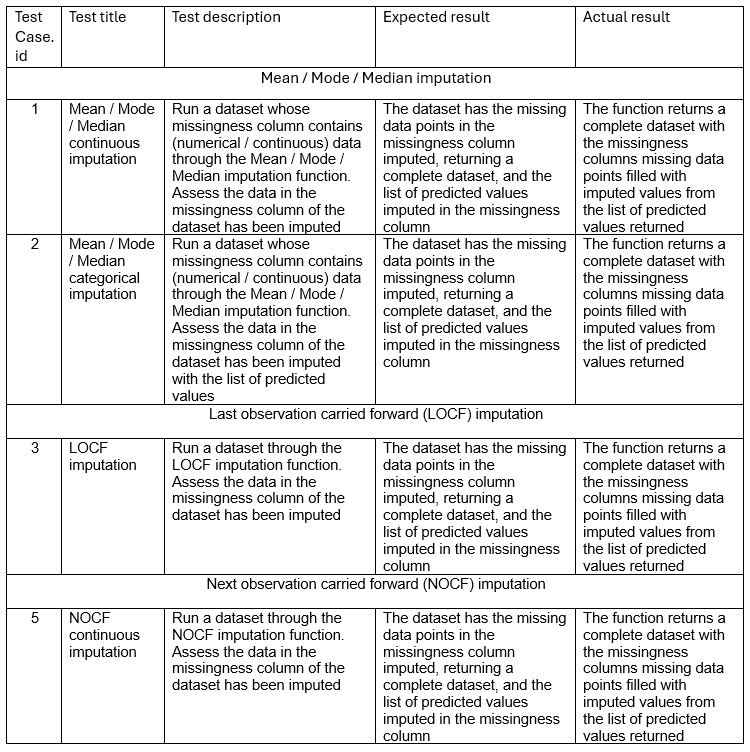!

#### Test 1 - Mean / Mode / Median continuous imputation
Run a dataset whose missingness column contains (numerical / continuous) data through the Mean / Mode / Median imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = mean_mode_median_imputation(df, "fips", False)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
         date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65 


After dataframe: 
         date    county    state         fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.000000  11018     160
1 2022-01-01   Baldwin  Alabama  1003.000000  39911     593
2 2022-01-01   Barbour  Alabama  1005.000000   3860      81
3 2022-01-01      Bibb  Alabama  1007.000000   4533      95
4 2022-01-01    Blount  Alabama  1009.000000  11256  

<ipython-input-6-eb7e0bef176d>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mean(), inplace=True)


#### Test 2 - Mean / Mode / Median categorical imputation
Run a dataset whose missingness column contains (numerical / continuous) data through the Mean / Mode / Median imputation function. Assess the data in the missingness column of the dataset has been imputed with the list of predicted values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = mean_mode_median_imputation(df, "state", True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

<ipython-input-6-eb7e0bef176d>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(df[column].mode()[0], inplace=True)


#### Test 3 - LOCF imputation
Run a dataset through the LOCF imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = locf_imputation(df, "state")
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

<ipython-input-7-c81dbf4c7793>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(method='ffill', inplace=True)
<ipython-input-7-c81dbf4c7793>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)


#### Test 4 - NOCF imputation
Run a dataset through the NOCF imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = locf_imputation(df, "state")
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

<ipython-input-7-c81dbf4c7793>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(method='ffill', inplace=True)
<ipython-input-7-c81dbf4c7793>:16: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[column].fillna(method='ffill', inplace=True)


### Manual functional testing for Advanced imputation functions

Manual testing is executed to a specification (test case specification) which requires human intervention (manual execution by testers) without the use of any automation tools

<br>

### Test case specification:
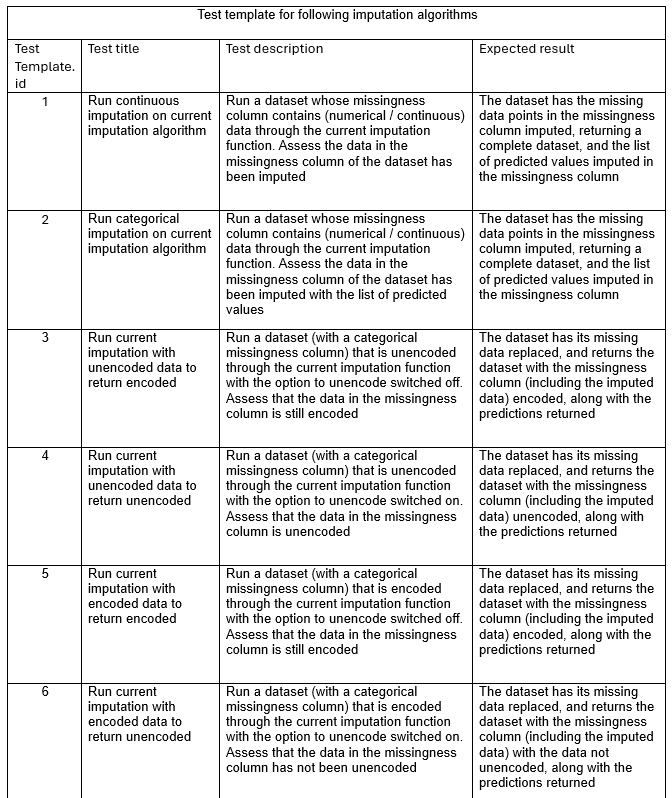
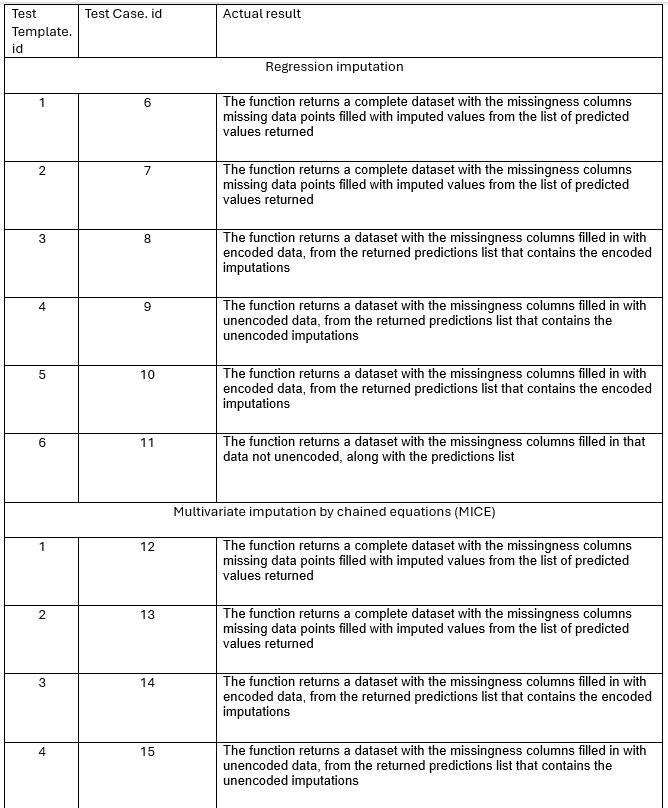
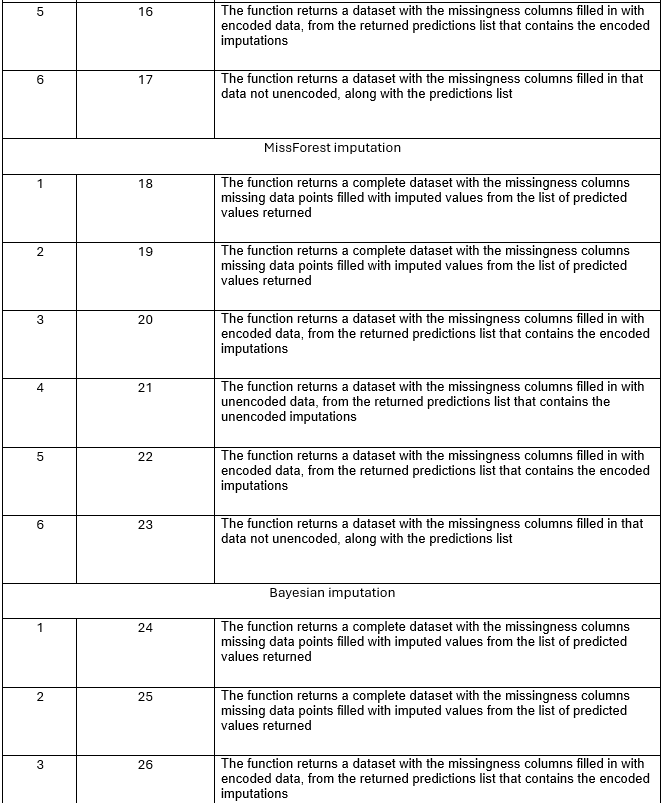
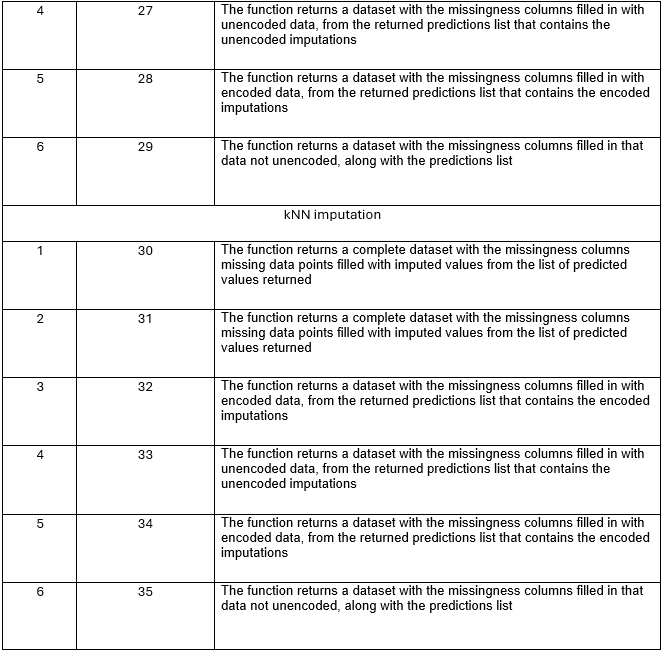

#### Test 5 - Run continuous Regression imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=100)





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = regression_imputation(df, "fips", False, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date    county           state    fips  cases  deaths
0  2022-01-01   Autauga         Alabama  1001.0  11018     160
1  2022-01-01   Baldwin         Alabama  1003.0  39911     593
2  2022-01-01   Barbour         Alabama  1005.0   3860      81
3  2022-01-01      Bibb         Alabama  1007.0   4533      95
4  2022-01-01    Blount         Alabama  1009.0  11256     198
..        ...       ...             ...     ...    ...     ...
95 2022-01-01   Unknown  American Samoa     NaN     11       0
96 2022-01-01    Apache         Arizona  4001.0  16324     542
97 2022-01-01   Cochise         Arizona  4003.0  20157     469
98 2022-01-01  Coconino         Arizona  4005.0  28256     416
99 2022-01-01      Gila         Arizona  4007.0  12274     311

[100 rows x 6 columns] 


After dataframe: 
          date    county           state         fips  cases  deaths
0  2022-01-01   Autauga         Alabama  1001.000000  11018     160
1  2022-01-01   Baldwin         Alabama  1

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


#### Test 6 - Run categorical Regression imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed with the list of predicted values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]
df.loc[10, "state"] = "Manhattan"



"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = regression_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county      state    fips  cases  deaths
10 2021-01-01    Chilton  Manhattan  1021.0   3004      54
11 2021-01-01    Choctaw    Alabama  1023.0    491      22
12 2021-01-01     Clarke    Alabama  1025.0   2418      26
13 2021-01-01       Clay    Alabama  1027.0   1150      34
14 2021-01-01   Cleburne    Alabama  1029.0   1036      16
15 2021-01-01     Coffee    Alabama  1031.0   3643      38
16 2021-01-01    Colbert    Alabama  1033.0   4701      60
17 2021-01-01    Conecuh       None  1035.0    839      17
18 2021-01-01      Coosa    Alabama  1037.0    519       7
19 2021-01-01  Covington    Alabama  1039.0   2931      40 




<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3004' '491' '2418' '1150' '1036' '3643' '4701' '519' '2931']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['54' '22' '26' '34' '16' '38' '60' '7' '40']' has dtype in

After dataframe: 
          date     county      state    fips  cases  deaths
10 2021-01-01    Chilton  Manhattan  1021.0   3004      54
11 2021-01-01    Choctaw    Alabama  1023.0    491      22
12 2021-01-01     Clarke    Alabama  1025.0   2418      26
13 2021-01-01       Clay    Alabama  1027.0   1150      34
14 2021-01-01   Cleburne    Alabama  1029.0   1036      16
15 2021-01-01     Coffee    Alabama  1031.0   3643      38
16 2021-01-01    Colbert    Alabama  1033.0   4701      60
17 2021-01-01    Conecuh    Alabama  1035.0    839      17
18 2021-01-01      Coosa    Alabama  1037.0    519       7
19 2021-01-01  Covington    Alabama  1039.0   2931      40 


['Alabama']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Test 7 - Run Regression imputation with unencoded data to return encoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched off. Assess that the data in the missingness column is still encoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]
df.loc[10, "state"] = "Manhattan"




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = regression_imputation(df, "state", True, False)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county      state    fips  cases  deaths
10 2021-01-01    Chilton  Manhattan  1021.0   3004      54
11 2021-01-01    Choctaw    Alabama  1023.0    491      22
12 2021-01-01     Clarke    Alabama  1025.0   2418      26
13 2021-01-01       Clay    Alabama  1027.0   1150      34
14 2021-01-01   Cleburne    Alabama  1029.0   1036      16
15 2021-01-01     Coffee    Alabama  1031.0   3643      38
16 2021-01-01    Colbert    Alabama  1033.0   4701      60
17 2021-01-01    Conecuh       None  1035.0    839      17
18 2021-01-01      Coosa    Alabama  1037.0    519       7
19 2021-01-01  Covington    Alabama  1039.0   2931      40 


After dataframe: 
          date     county      state    fips  cases  deaths
10 2021-01-01    Chilton  Manhattan  1021.0   3004      54
11 2021-01-01    Choctaw    Alabama  1023.0    491      22
12 2021-01-01     Clarke    Alabama  1025.0   2418      26
13 2021-01-01       Clay    Alabama  1027.0   1150      34
14 2021-01-01 

<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3004' '491' '2418' '1150' '1036' '3643' '4701' '519' '2931']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['54' '22' '26' '34' '16' '38' '60' '7' '40']' has dtype in

#### Test 8 - Run Regression imputation with unencoded data to return unencoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched on. Assess that the data in the missingness column is unencoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]
df.loc[10, "state"] = "Manhattan"




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = regression_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county      state    fips  cases  deaths
10 2021-01-01    Chilton  Manhattan  1021.0   3004      54
11 2021-01-01    Choctaw    Alabama  1023.0    491      22
12 2021-01-01     Clarke    Alabama  1025.0   2418      26
13 2021-01-01       Clay    Alabama  1027.0   1150      34
14 2021-01-01   Cleburne    Alabama  1029.0   1036      16
15 2021-01-01     Coffee    Alabama  1031.0   3643      38
16 2021-01-01    Colbert    Alabama  1033.0   4701      60
17 2021-01-01    Conecuh       None  1035.0    839      17
18 2021-01-01      Coosa    Alabama  1037.0    519       7
19 2021-01-01  Covington    Alabama  1039.0   2931      40 




<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3004' '491' '2418' '1150' '1036' '3643' '4701' '519' '2931']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-9-e9c1b69fc23e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['54' '22' '26' '34' '16' '38' '60' '7' '40']' has dtype in

After dataframe: 
          date     county      state    fips  cases  deaths
10 2021-01-01    Chilton  Manhattan  1021.0   3004      54
11 2021-01-01    Choctaw    Alabama  1023.0    491      22
12 2021-01-01     Clarke    Alabama  1025.0   2418      26
13 2021-01-01       Clay    Alabama  1027.0   1150      34
14 2021-01-01   Cleburne    Alabama  1029.0   1036      16
15 2021-01-01     Coffee    Alabama  1031.0   3643      38
16 2021-01-01    Colbert    Alabama  1033.0   4701      60
17 2021-01-01    Conecuh    Alabama  1035.0    839      17
18 2021-01-01      Coosa    Alabama  1037.0    519       7
19 2021-01-01  Covington    Alabama  1039.0   2931      40 


['Alabama']


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


#### Test 9 - Run continuous MICE imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = mice_imputation(df, "fips", False, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
         date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65 


After dataframe: 
         date    county    state         fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.000000  11018     160
1 2022-01-01   Baldwin  Alabama  1003.000000  39911     593
2 2022-01-01   Barbour  Alabama  1005.000000   3860      81
3 2022-01-01      Bibb  Alabama  1007.000000   4533      95
4 2022-01-01    Blount  Alabama  1009.000000  11256  

#### Test 10 - Run categorical MICE imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed with the list of predicted values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = mice_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

#### Test 11 - Run MICE imputation with unencoded data to return encoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched off. Assess that the data in the missingness column is still encoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = mice_imputation(df, "state", True, False)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county state    fips  cases  deaths
10 2021-01-01    Chilton   NaN  1021.0   3004      54
11 2021-01-01    Choctaw   NaN  1023.0    491      22
12 2021-01-01     Clarke   NaN  1025.0   2418      26
13 2021-01-01       Clay   NaN  1027.0   1150      34
14 2021-01-01   Cleburne   NaN  1029.0   1036      16
15 2021

<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

#### Test 12 - Run MICE imputation with unencoded data to return unencoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched on. Assess that the data in the missingness column is unencoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = mice_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-10-97694299c96e>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

#### Test 13 - Run continuous MissForest imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = missforest_imputation(df, "fips", False, False, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "


Before dataframe: 
         date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65 




100%|██████████| 5/5 [00:00<00:00, 18.14it/s]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 129.45it/s]

After dataframe: 
         date    county    state         fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.000000  11018     160
1 2022-01-01   Baldwin  Alabama  1003.000000  39911     593
2 2022-01-01   Barbour  Alabama  1005.000000   3860      81
3 2022-01-01      Bibb  Alabama  1007.000000   4533      95
4 2022-01-01    Blount  Alabama  1009.000000  11256     198
5 2022-01-01   Bullock  Alabama  1006.329932   1676      46
6 2022-01-01    Butler  Alabama  1013.000000   3613     102
7 2022-01-01   Calhoun  Alabama  1006.329932  23411     532
8 2022-01-01  Chambers  Alabama  1006.329932   6171     147
9 2022-01-01  Cherokee  Alabama  1006.329932   3385      65 


[1006.329931640625, 1006.329931640625, 1006.329931640625, 1006.329931640625]


#### Test 14 - Run categorical MissForest imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed with the list of predicted values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = missforest_imputation(df, "state", True, False, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 




100%|██████████| 5/5 [00:00<00:00, 19.45it/s]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 160.97it/s]

After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh  Alabama  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


['Alabama']


#### Test 15 - Run MissForest imputation with unencoded data to return encoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched off. Assess that the data in the missingness column is still encoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = missforest_imputation(df, "state", True, False)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 




100%|██████████| 5/5 [00:00<00:00, 21.01it/s]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 161.29it/s]

After dataframe: 
          date     county state    fips  cases  deaths
10 2021-01-01    Chilton   0.0  1021.0   3004      54
11 2021-01-01    Choctaw   0.0  1023.0    491      22
12 2021-01-01     Clarke   0.0  1025.0   2418      26
13 2021-01-01       Clay   0.0  1027.0   1150      34
14 2021-01-01   Cleburne   0.0  1029.0   1036      16
15 2021-01-01     Coffee   0.0  1031.0   3643      38
16 2021-01-01    Colbert   0.0  1033.0   4701      60
17 2021-01-01    Conecuh   0.0  1035.0    839      17
18 2021-01-01      Coosa   0.0  1037.0    519       7
19 2021-01-01  Covington   0.0  1039.0   2931      40 


[0.0]


#### Test 16 - Run MissForest imputation with unencoded data to return unencoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched on. Assess that the data in the missingness column is unencoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = missforest_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-11-58656953ce43>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 




100%|██████████| 5/5 [00:00<00:00, 27.31it/s]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process "
100%|██████████| 5/5 [00:00<00:00, 210.84it/s]

After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh  Alabama  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


['Alabama']


#### Test 17 - Run continuous Bayesian imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = bayesian_imputation(df, "fips", False, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
         date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65 


After dataframe: 
         date    county    state         fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.000000  11018     160
1 2022-01-01   Baldwin  Alabama  1003.000000  39911     593
2 2022-01-01   Barbour  Alabama  1005.000000   3860      81
3 2022-01-01      Bibb  Alabama  1007.000000   4533      95
4 2022-01-01    Blount  Alabama  1009.000000  11256  

#### Test 18 - Run categorical Bayesian imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed with the list of predicted values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = bayesian_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3004' '491' '2418' '1150' '1036' '3643' '4701' '519' '2931']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['54' '22' '26' '34' '16' '38' '60' '7' '40']' has dtype

#### Test 19 - Run Bayesian imputation with unencoded data to return encoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched off. Assess that the data in the missingness column is still encoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = bayesian_imputation(df, "state", True, False)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3004' '491' '2418' '1150' '1036' '3643' '4701' '519' '2931']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['54' '22' '26' '34' '16' '38' '60' '7' '40']' has dtype

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

#### Test 20 - Run Bayesian imputation with unencoded data to return unencoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched on. Assess that the data in the missingness column is unencoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = bayesian_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['3004' '491' '2418' '1150' '1036' '3643' '4701' '519' '2931']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-78-78b8d195e5ee>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['54' '22' '26' '34' '16' '38' '60' '7' '40']' has dtype

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   10

#### Test 21 - Run continuous kNN imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)





"""Run the test"""

# Run the imputation function for a continuous column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = kNN_imputation(df, "fips", False, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
         date    county    state    fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.0  11018     160
1 2022-01-01   Baldwin  Alabama  1003.0  39911     593
2 2022-01-01   Barbour  Alabama  1005.0   3860      81
3 2022-01-01      Bibb  Alabama  1007.0   4533      95
4 2022-01-01    Blount  Alabama  1009.0  11256     198
5 2022-01-01   Bullock  Alabama     NaN   1676      46
6 2022-01-01    Butler  Alabama  1013.0   3613     102
7 2022-01-01   Calhoun  Alabama     NaN  23411     532
8 2022-01-01  Chambers  Alabama     NaN   6171     147
9 2022-01-01  Cherokee  Alabama     NaN   3385      65 


Imputing row 1/10 with 0 missing, elapsed time: 0.002
After dataframe: 
         date    county    state         fips  cases  deaths
0 2022-01-01   Autauga  Alabama  1001.000000  11018     160
1 2022-01-01   Baldwin  Alabama  1003.000000  39911     593
2 2022-01-01   Barbour  Alabama  1005.000000   3860      81
3 2022-01-01      Bibb  Alabama  1007.000000   4533      95

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Test 22 - Run categorical kNN imputation on current imputation algorithm
Run a dataset whose missingness column contains (numerical / continuous) data through the current imputation function. Assess the data in the missingness column of the dataset has been imputed with the list of predicted values

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = kNN_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


Imputing row 1/10 with 0 missing, elapsed time: 0.000
After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150 

<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

#### Test 23 - Run kNN imputation with unencoded data to return encoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched off. Assess that the data in the missingness column is still encoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = kNN_imputation(df, "state", True, False)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


Imputing row 1/10 with 0 missing, elapsed time: 0.001
After dataframe: 
          date     county state    fips  cases  deaths
10 2021-01-01    Chilton   NaN  1021.0   3004      54
11 2021-01-01    Choctaw   NaN  1023.0    491      22
12 2021-01-01     Clarke   NaN  1025.0   2418      26
13 2021-01-01       Clay   NaN  1027.0   1150      34
14 2021

<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

#### Test 24 - Run kNN imputation with unencoded data to return unencoded
Run a dataset (with a categorical missingness column) that is unencoded through the current imputation function with the option to unencode switched on. Assess that the data in the missingness column is unencoded

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"

# Get a dataset to test the imputation function
df = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]




"""Run the test"""

# Run the imputation function for a classification column
print(f"Before dataframe: \n {df} \n\n")
df, predictions = kNN_imputation(df, "state", True, True)
print(f"After dataframe: \n {df} \n\n")
print(predictions)

Before dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150      34
14 2021-01-01   Cleburne  Alabama  1029.0   1036      16
15 2021-01-01     Coffee  Alabama  1031.0   3643      38
16 2021-01-01    Colbert  Alabama  1033.0   4701      60
17 2021-01-01    Conecuh     None  1035.0    839      17
18 2021-01-01      Coosa  Alabama  1037.0    519       7
19 2021-01-01  Covington  Alabama  1039.0   2931      40 


Imputing row 1/10 with 0 missing, elapsed time: 0.001
After dataframe: 
          date     county    state    fips  cases  deaths
10 2021-01-01    Chilton  Alabama  1021.0   3004      54
11 2021-01-01    Choctaw  Alabama  1023.0    491      22
12 2021-01-01     Clarke  Alabama  1025.0   2418      26
13 2021-01-01       Clay  Alabama  1027.0   1150 

<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

### Manual functional testing for imputation assessment functions
Manual testing is executed to a specification (test case specification) which requires human intervention (manual execution by testers) without the use of any automation tools

<br>

### Test case specification:
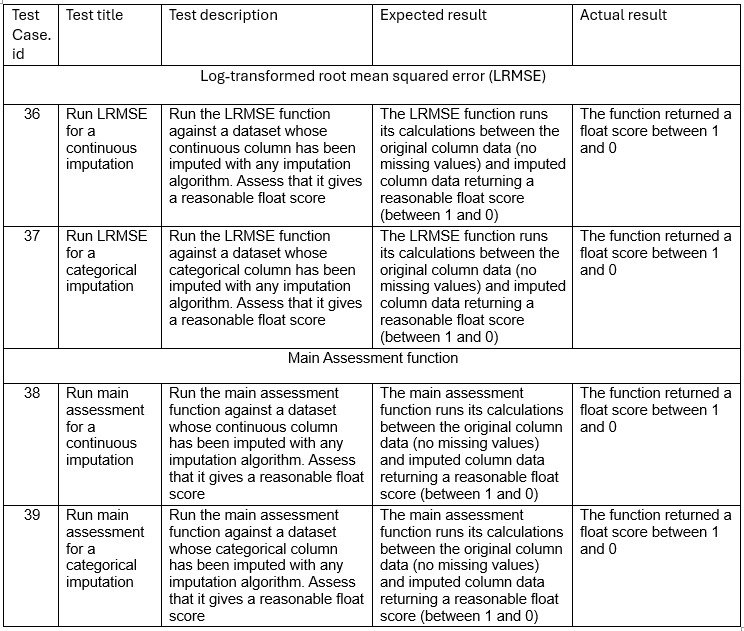

#### Test 25 - Run LRMSE for a continuous imputation
Run the LRMSE function against a dataset whose continuous column has been imputed with any imputation algorithm. Assess that it gives a reasonable float score

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"
original_path = "./data/Original"

# Get a dataset to test the imputation function
df_continuous = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

missingness_map = df_continuous["fips"].isna()

# Run the imputation function for a continuous column
df_continuous, column_imputed = kNN_imputation(df_continuous, "fips", False, True)




"""Run the test"""

# Get the datasets to assess the imputation function
df_continuous_original = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

# Create the imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
imputed_data = imputer.fit_transform(np.array(df_continuous_original["fips"]).reshape(-1, 1))

# Convert back to DataFrame
df_continuous_original["fips"] = np.array(imputed_data)

column_original = list(df_continuous_original[missingness_map]["fips"])


# Test continuous dataset
print("Test continuous dataset ----------------------------------------------")
print(f"Original column: \n {column_original} \n\n")
print(f"Imputed column: \n {column_imputed} \n\n")
print("LRMSE: " + str(LRMSE(column_original, column_imputed, False)) + "\n\n")
print("Manually calulated LRMSE: 0.0029000322 \n\n")

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Test continuous dataset ----------------------------------------------
Original column: 
 [1006.3333333333334, 1006.3333333333334, 1006.3333333333334, 1006.3333333333334] 


Imputed column: 
 [1008.823228731949, 1004.9685164720665, 1007.4592941673483, 1011.320821618802] 


LRMSE: 0.0029000322491595306


Manually calulated LRMSE: 0.0029000322 




/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Test 26 - Run LRMSE for a categorical imputation
Run the LRMSE function against a dataset whose categorical column has been imputed with any imputation algorithm. Assess that it gives a reasonable float score

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"
original_path = "./data/Original"

# Get a dataset to test the imputation function
df_categorical = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]

missingness_map = df_categorical["state"].isna()

# Run the imputation function for a continuous column
df_categorical, column_imputed = kNN_imputation(df_categorical, "state", True, True)




"""Run the test"""

# Get the datasets to assess the imputation function
df_categorical_original = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]

df_categorical_original.isna()["state"] = "Manhattan"

column_original = list(df_categorical_original[missingness_map]["state"])


# Test continuous dataset
print("Test continuous dataset ----------------------------------------------")
print(f"Original column: \n {column_original} \n\n")
print(f"Imputed column: \n {column_imputed} \n\n")
print("LRMSE: " + str(LRMSE(column_original, column_imputed, True)) + "\n\n")
print("Manually calulated LRMSE: 0.0 \n\n")

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Test continuous dataset ----------------------------------------------
Original column: 
 [None] 


Imputed column: 
 ['Alabama'] 


LRMSE: 0.0


Manually calulated LRMSE: 0.0 




<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 

#### Test 27 - Run main assessment for a continuous imputation
Run the main assessment function against a dataset whose continuous column has been imputed with any imputation algorithm. Assess that it gives a reasonable float score

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"
original_path = "./data/Original"

# Get a dataset to test the imputation function
df_continuous = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

missingness_map = df_continuous["fips"].isna()

# Run the imputation function for a continuous column
df_continuous, column_imputed = kNN_imputation(df_continuous, "fips", False, True)




"""Run the test"""

# Get the datasets to assess the imputation function
df_continuous_original = pd.read_json(os.path.join(mcar_path, "us-counties-2022.json"), lines=True, nrows=10)

# Create the imputer
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
imputed_data = imputer.fit_transform(np.array(df_continuous_original["fips"]).reshape(-1, 1))

# Convert back to DataFrame
df_continuous_original["fips"] = np.array(imputed_data)

column_original = list(df_continuous_original[missingness_map]["fips"])


# Test continuous dataset
print("Test continuous dataset ----------------------------------------------")
print(f"Original column: \n {column_original} \n\n")
print(f"Imputed column: \n {column_imputed} \n\n")
print("Main assessment: " + str(main_assessment(column_original, column_imputed, False)) + "\n\n")
print("Manually calulated main assessment: 344.8237516 \n\n")

Imputing row 1/10 with 0 missing, elapsed time: 0.001
Test continuous dataset ----------------------------------------------
Original column: 
 [1006.3333333333334, 1006.3333333333334, 1006.3333333333334, 1006.3333333333334] 


Imputed column: 
 [1008.823228731949, 1004.9685164720665, 1007.4592941673483, 1011.320821618802] 


Main assessment: 344.82375162890474


Manually calulated main assessment: 344.8237516 




/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


#### Test 28 - Run main assessment for a categorical imputation
Run the main assessment function against a dataset whose categorical column has been imputed with any imputation algorithm. Assess that it gives a reasonable float score

In [ ]:
"""Initialise variables to run the test"""

# Specify the paths to download the datasets
download_path = './datasets'
mcar_path = "./data/MCAR"
original_path = "./data/Original"

# Get a dataset to test the imputation function
df_categorical = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]

missingness_map = df_categorical["state"].isna()

# Run the imputation function for a continuous column
df_categorical, column_imputed = kNN_imputation(df_categorical, "state", True, True)




"""Run the test"""

# Get the datasets to assess the imputation function
df_categorical_original = pd.read_json(os.path.join(mcar_path, "us-counties-2021.json"), lines=True).iloc[10:20]

df_categorical_original.isna()["state"] = "Manhattan"

column_original = list(df_categorical_original[missingness_map]["state"])


# Test continuous dataset
print("Test continuous dataset ----------------------------------------------")
print(f"Original column: \n {column_original} \n\n")
print(f"Imputed column: \n {column_imputed} \n\n")
print("Main assessment: " + str(main_assessment(column_original, column_imputed, True)) + "\n\n")
print("Manually calulated main assessment: 0.0 \n\n")

Imputing row 1/10 with 0 missing, elapsed time: 0.000
Test continuous dataset ----------------------------------------------
Original column: 
 [None] 


Imputed column: 
 ['Alabama'] 


Main assessment: 0.0


Manually calulated main assessment: 0.0 




<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '0' '0' '0' '0' '0' '0' '0' '0']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['0' '1' '2' '3' '4' '5' '6' '8' '9']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df[df[column].notna()] = df[df[column].notna()].astype(str)
<ipython-input-13-9499f8395aed>:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['1021.0' '1023.0' '1025.0' '1027.0' '1029.0' '1031.0' '1033.0' '1037.0'
 '1039.0']' has dtype incompatible with float64, please 